Во [вложении]() выгрузка данных из яндекс-формы.

Задача, провести исследование.

Ответ + код лучше в колабе или * ipynb , или дашборды
 

Пример, как мы это сейчас визуализировали один из вопросов и отображение ответов:

![](images/image002.jpg)<br>
![](images/image003.jpg)<br>

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from urllib.request import urlopen
import json
import plotly.express as px

# Знакомство с данными

In [3]:
# путь к файлу
file_path='files/2025.06.23.15.00test.xlsx'
# записываем в датафрейм файл
data= pd.read_excel(file_path)
# смотрим на случайную строку
data.sample(n=1, random_state=42).T

,30
ID,NaN
Время создания,NaN
Наименование организации:,"ООО ""Альфа Телеком Стандарт"""
Регион,Республика Татарстан (Татарстан)
Город,Набережные Челны
...,...
Какие геоинформационные операции могут быть наиболее востребованы и были бы полезны в вашей деятельности: / Создание анимаций. Визуализация динамики процессов (пример 1: распространение пожара; пример 2: рост города за 50 лет).,NaN
Какие геоинформационные операции могут быть наиболее востребованы и были бы полезны в вашей деятельности: / Иное,NaN
"Иные геоинформационные операции, которые востребованы в вашей деятельности",NaN
"Укажите идеи для геоинформационных сервисов и решений (включающие карты, пространственные данные, геоаналитику) под задачи, которые могли быть востребованы организацией:",NaN


Первично можно сказать, что датасет содержит информацию опросника организаций с указанием региона и города. Полей много и смотреть их в виде таблицы или графика в исходном виде будет неудобно. 

In [4]:
# Выводим информацию о размере датафрейма
print(f"Датасет содержит: {len(data)} строк, \
{data.shape[1]} столбцов")


Датасет содержит: 80 строк, 179 столбцов


In [5]:
#столбцов с определенным типом данных в датафрейме
data.dtypes.value_counts()

object     164
float64     15
Name: count, dtype: int64

Датасет содержит два типа данных: строки (object) и числовой (float64) Это означает, что данные содержат строки, а также либо число с плавающей точкой либо пропуски. При первом взгляде для полей `ID`тип данных обычно целочисленный/строковый, 	`Время создания` - datetime/time.

Посмотрим на пропуски.

In [6]:
print(f"Всего датасет содержит {data.isnull().values.sum()} пропусков.\n\
=========================================")
print('Медианное количество пропусков в каждом из',
data.shape[1], 'столбцов:', 
int(data.isna().sum().median()), 'или ', 
round((data.isna().sum().median() / len(data)) * 100), '% \n\
=========================================')
print('Cтолбцы без пропусков:')
# процент нулевых значений
cnt_full_col = 0
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    if pct_missing == 0:
        cnt_full_col +=1
        print("{}. {}".format(cnt_full_col, col))

Всего датасет содержит 9274 пропусков.
Медианное количество пропусков в каждом из 179 столбцов: 64 или  80 % 
Cтолбцы без пропусков:
1. Наименование организации:
2. Регион
3. Город
4. Знаете ли вы о запрете использования зарубежных геоинформационных технологий органами государственной власти с 1 января 2026 года, согласно Федеральному закону от 30.12.2015 № 431-ФЗ ‎«О геодезии, картографии и пространственных данных и о внесении изменений ‎в отдельные законодательные акты Российской Федерации»
5. Знали ли вы о существовании такого продукта прежде?
6. Готовы ли Вы ответить на несколько вопросов в рамках онлайн - интервью?


In [7]:
print('Cтолбцы со 100% пропусками:\n\
=========================================')
cnt_null_col = 0
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    if pct_missing == 1:
        cnt_null_col += 1
        print('{}. {}'.format(cnt_null_col, col))

Cтолбцы со 100% пропусками:
1. ID
2. Время создания
3. Отрасль/сфера деятельности: / Торговля и общественное питание
4. Отрасль/сфера деятельности: / Материально-техническое снабжение и сбыт
5. Отрасль/сфера деятельности: / Заготовки
6. Отрасль/сфера деятельности: / Общая коммерческая деятельность по обеспечению функционирования рынка
7. Отрасль/сфера деятельности: / Непроизводственные виды бытового обслуживания населения
8. Отрасль/сфера деятельности: / Финансы, кредит, страхование, пенсионное обеспечение
9. Отрасль/сфера деятельности: / Общественные объединения
10. Вид организации: / федеральный орган исполнительной власти (или его подразделение)
11. Вид организации: / орган исполнительной власти субъекта Российской Федерации (или его подразделение)
12. Респондент (сотрудник организации, заполнивший форму), ФИО:
13. Должность респондента  (сотрудника организации, заполнившего форму):
14. Контактный электронный адрес организации:
15. Контактный телефон организации:


Данные об `ID`  и  `Время создания ` отсутствуют, с большой долей вероятности это из-за предоставления для публичного просмотра. Такие же причины могут быть и у других столбцов со 100% пропусками.

На пропусках не будем заострять фокус по причине большого количества полей с ними. Просто  отмечаем этот факт, как требующий дополнительного исследования причин пропусков. Дополнительно отметим, что эти пропуски могут быть как естественными/нормальными, так и сигналом к поиску их причины.

Проверить на наличие явных дубликатов без ключевого поля `ID` для компаний нельзя. Посмотрим есть ли совпадения по трем полям, в которых нет пропусков:
 - `Наименование организации: `
 - `Регион `  
 - `Город  ` 

In [8]:
#посчитаем  дубликаты по конкретным полям
print(f"Количество дубликатов по полям \
'Наименование организации:', 'Регион', 'Город': \
{data[['Наименование организации:', 'Регион', 'Город']].
duplicated().sum()} шт.")

Количество дубликатов по полям 'Наименование организации:', 'Регион', 'Город': 0 шт.


In [9]:
# list(data.columns)

Посчитаем уникальные значения в столбцах некоторых полей и посмотрим на уникальные значения одного полей.


In [10]:
col_list = ['Наименование организации:', 
            'Регион', 
            'Город']
# Проверяем количество уникальные значения в столбцах всего датафрейма
print('Уникальных значений:')
for column in data[col_list]:
    print(f'{data[column].nunique()} в столбце: "{column}"')


Уникальных значений:
79 в столбце: "Наименование организации:"
29 в столбце: "Регион"
57 в столбце: "Город"


In [11]:
data['Вид деятельности организации'].unique()

array([nan, 'Проектирование и изыскания', 'Частная организация',
       'пенсионер с огромным опытом работ и знаниями за пределами действующих регламентов в технологиях завтрашнего дня.С опытом работ и преподавания геоинформационных дисциплин вв 12ти странах мира. с долгами по неоплате заказчиков - победителей госконтрактов.',
       'Федеральное государственное бюджетное учреждение науки',
       'Коммерческая организация', 'Коммерческая частная компания',
       'Инженерные изыскания',
       'Общество с ограниченной ответственностью ',
       'Разработка компьютерного программного обеспечения',
       'Проектирование и осуществление функций технического заказчика',
       'Индивидуальный Предприниматель',
       'Общество с ограниченной ответственностью',
       'Индивидуальный предприниматель',
       'Электромонтажные работы и обслуживание систем противопожарной безопасности',
       'Общество с ограниченной ответственностью.', 'Стьроительство',
       'частная собственность',
   

Данные по полю `Вид деятельности организации` скорее всего внесены без выбора (введены вручную), что требует дополнительной обработки, группировки с предварительным пониманием того, что подразумевается под "вид деятельности организации". 

Даже при незначительных (80 организаций) размерах датасета данные внесены разные: форма собственности, юридическое оформление (ИП, ООО), оквэд в кодировке и расшифровке. А с увеличением строк увеличатся и ошибки и разброс данных. Из рекомендаций - зафиксировать виды деятельности и дать пользователю возможность выбирать, а не печатать данные.

Стоит также проанализировать и другие поля на уровне формы для заполнения и во всех случаях, когда есть возможность указать список значений - сделать именно так.

Посмотрим на целевые поля из референса, а именно нас интересуют 
 - количество упоминаний по регионам в абсолютном и относительном значении
 - Подсчет значений  в Поле "Знали ли вы о существовании такого продукта прежде?" в абсолютном и относительном значении
 - Подсчет значений в Поле "Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?"


In [12]:
# в список фиксируем интересующие поля 
col_list = ['Знали ли вы о существовании такого продукта прежде?',
            'Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?',
            'Регион'
           ]
# смотрим какие уникальные значения в интересующих полях               
for i, col in enumerate(col_list):
    print('В поле: "{}"\n{} уникальных значения: {}\
\n'.format(col_list[i],
         data[col].nunique(),
         list(data[col].unique())
        )    
         )

В поле: "Знали ли вы о существовании такого продукта прежде?"
2 уникальных значения: ['Да', 'Нет']

В поле: "Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?"
4 уникальных значения: ['нет, потребность отсутствует', 'да (уже используем)', 'да (пока не используется, хотели бы использовать)', 'требуется более подробная информация о продукте', nan]

В поле: "Регион"
29 уникальных значения: ['Московская область', 'Санкт-Петербург', 'Новосибирская область', 'Краснодарский край', 'Москва', 'Тюменская область', 'Свердловская область', 'Сахалинская область', 'Иркутская область', 'Донецкая Народная Республика', 'Омская область', 'Самарская область', 'Амурская область', 'Волгоградская область', 'Кемеровская область - Кузбасс', 'Белгородская область', 'Республика Татарстан (Татарстан)', 'Пензенская область', 'Пермский край', 'Калужская область', 'Липецкая область', 'Мурманская область', 'Тамбовская область', 'Хабаровский

Значения в полях не вызывают вопросов. 
# Цифровой ортофотоплан

## Знали ли вы о существовании такого продукта прежде?" 
Посчитаем количество ответов и их долю В поле: "Знали ли вы о существовании такого продукта прежде?"

In [13]:
# для нужного поля по индексу из col_list посчитаем  нужное
print(col_list[0],
'\nОбщее количество ответов:', data[col_list[0]].count(),     )

answer1 = (data[col_list[0]]
           .value_counts(dropna=False)
           .reset_index())
# переименуем поля
answer1.columns = ['Ответ', 'Количество']
answer1['Процент, %'] = round(
    answer1['Количество'] / 
    answer1['Количество'].sum() * 100
                         , 2)
# посмотрим что получилос
answer1

Знали ли вы о существовании такого продукта прежде? 
Общее количество ответов: 80


,Ответ,Количество,"Процент, %"
0,Да,48,60.0
1,Нет,32,40.0


Добавим визуализацию пайчарт для полученных данных

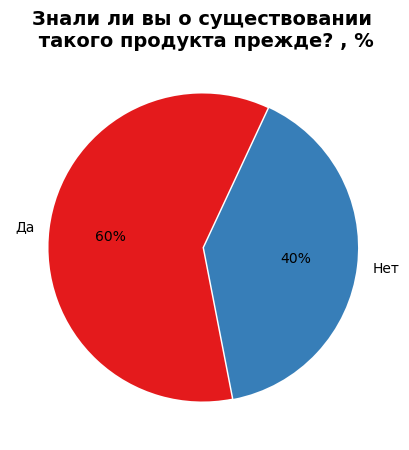

In [14]:
# зададим размеры фигуры
plt.figure(figsize=(5,5))
# определим расстояние междучастями пайчарта
explode = [0, 0.01] 
# определим цветовую палитру 
palette_color = sns.color_palette('Set1') 
  
# задаем параметры для пайчарта
plt.pie(answer1['Количество'], 
        labels=answer1['Ответ'], 
        colors=palette_color, 
        explode=explode, 
        startangle=65, # поворот пайчарта
        autopct='%.0f%%') 
 #подписываем график
plt.title('Знали ли вы о существовании\n такого продукта прежде? , %',
         fontsize=14, fontweight="bold")

#выводим график
plt.show()  

60% респондентов утверждают, что знали о продукте прежде.

## Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций?


In [15]:
# для нужного поля по индексу из col_list посчитаем  нужное
print(col_list[1],
'\nОбщее количество ответов:', data[col_list[1]].count())

answer2 = (data[col_list[1]]
           .value_counts(dropna=True)
           .reset_index())
# переименуем поля
answer2.columns = ['Значение', 'Количество']
answer2['Процент, %'] = round(
    answer2['Количество'] / 
    answer2['Количество'].sum() * 100
                         , 2)
# посмотрим что получилос
answer2

Существует ли потребность в данном продукте для решения специализированных задач подразделения и подведомственных организаций? 
Общее количество ответов: 79


,Значение,Количество,"Процент, %"
0,"нет, потребность отсутствует",30,37.97
1,"да (пока не используется, хотели бы использовать)",26,32.91
2,да (уже используем),19,24.05
3,требуется более подробная информация о продукте,4,5.06


Добавим визуализациидля получившейся информации: диаграмму и пайчарт.

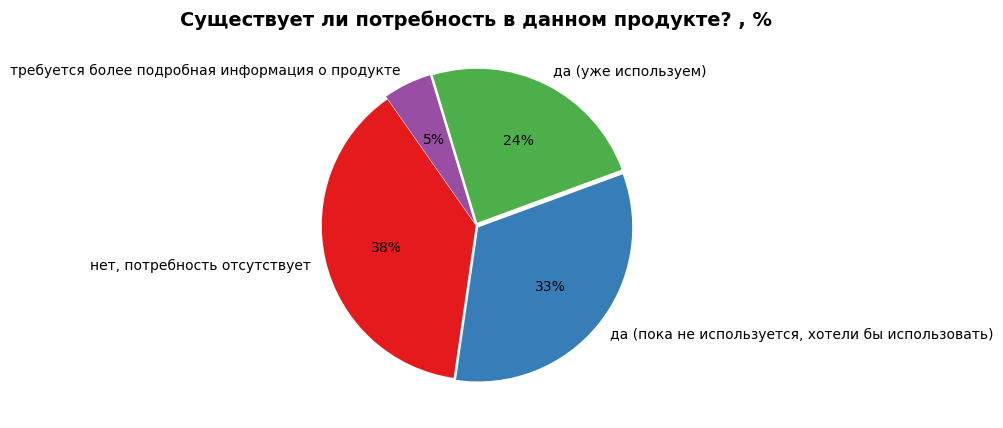

In [16]:
# зададим размеры фигуры
plt.figure(figsize=(5,5))
# определим расстояние междучастями пайчарта
explode = [0, 0.02, 0.02, 0.02] 
# определим цветовую палитру 
palette_color = sns.color_palette('Set1') 
  
# задаем параметры для пайчарта
plt.pie(answer2['Количество'], 
        labels=answer2['Значение'], 
        colors=palette_color, 
        explode=explode, 
        startangle=125, # поворот пайчарта
        autopct='%.0f%%') 
 #подписываем график
plt.title('Существует ли потребность в данном продукте? , %',
         fontsize=14, fontweight="bold")

#выводим график
plt.show()  

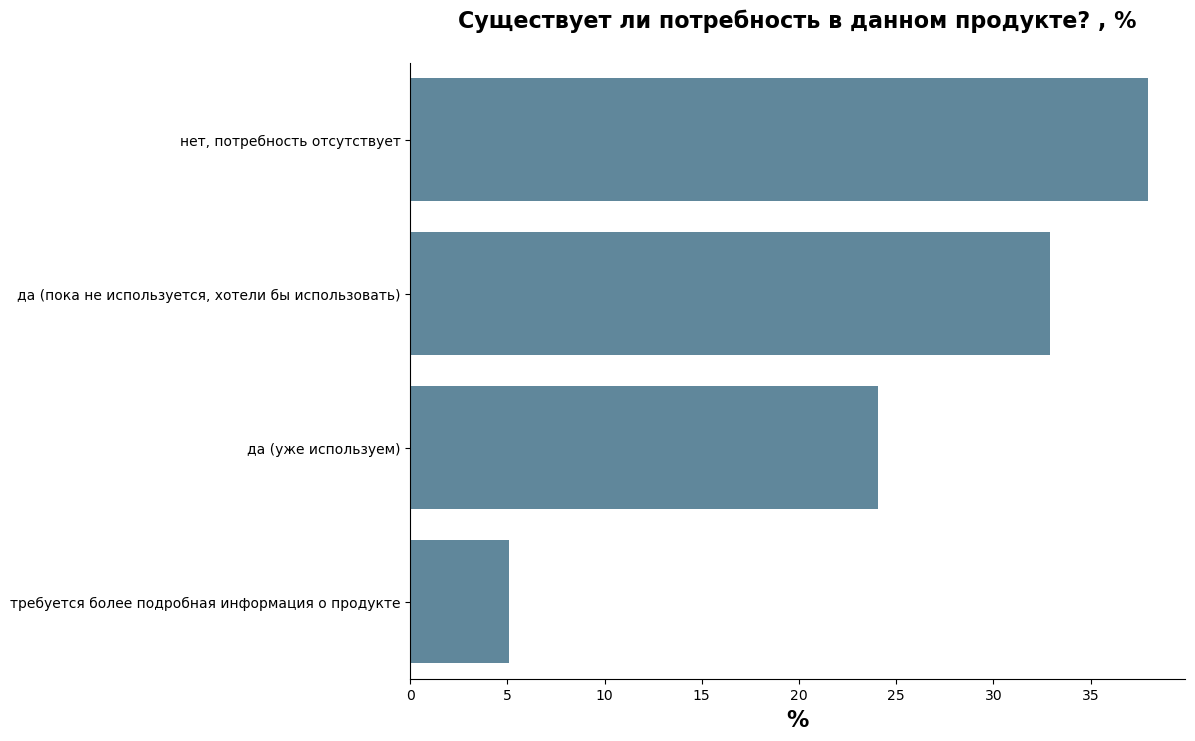

In [17]:
#строим график
plt.figure(figsize=(10,8))

sns.barplot(data=answer2,
            y='Значение', 
            x='Процент, %',
            color='#447D9B',       # цвет столбцов
            legend='auto',
            alpha=0.9)
           
#подписываем график
plt.title('Существует ли потребность в данном продукте? , %\n',
         fontsize=16, fontweight="bold")

#добавляем подписи по осям Х,убираем по оси У
plt.ylabel('')
plt.xlabel('%',fontsize = 16, fontweight ='bold')
           
#уберем границы в графике
sns.despine()
#выводим график
plt.show()

In [25]:
url = 'files/ru.geojson'
with urlopen(url) as responce:
    counties = json.load(responce)

ValueError: unknown url type: 'files/ru.geojson'

Получаем словарь counties. Нас интересует `counties['features']` - он хранит список словарей для каждого региона. В нем хранятся `название`, `ID` и `геометрия региона`

В 'features' значений ровно столько, сколько административных единиц в РФ.

охраним в датафрейм ID регионов и их названий, чтобы в дальнейшем соединить эти значения для графика.

In [23]:
df = pd.DataFrame()
df['region'] = (
    [counties['features'][i]['properties']['name']
     for i in range(len(counties['features']))]          
               )

df['id'] = (
    [counties['features'][i]['properties']['cartodb_id']
         for i in range(len(counties['features']))]     
    
)
df = df.merge()

In [24]:
df

,regoin,id
0,Бурятия,10
1,Карачаево-Черкесская республика,13
2,Сахалинская область,11
3,Воронежская область,16
4,Томская область,18
...,...,...
78,Удмуртская республика,59
79,Вологодская область,55
80,Ингушетия,34
81,Челябинская область,24
